In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
path = 'data/files/train_1.csv'
df_train1 = pd.read_csv(path)
df_train1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


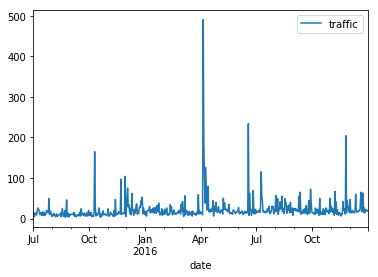

In [108]:
df_spider = df_train1.iloc[[0]].copy()
df_spider = df_spider.T.iloc[1:]
df_spider.index.name = 'date'
df_spider.reset_index(inplace=True)
df_spider.rename(columns={0: 'traffic'}, inplace=True)
df_spider['date'] = pd.to_datetime(df_spider['date'], format='%Y/%m/%d')
df_spider.set_index('date', inplace=True)
df_spider.traffic = pd.to_numeric(df_spider.traffic)
df_spider.plot();

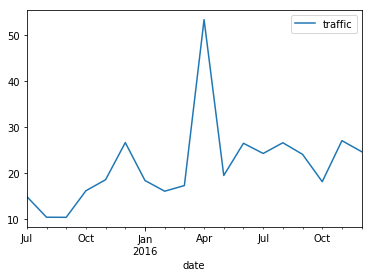

In [107]:
#monthly traffic
df_spider.resample('m').mean().plot();

In [228]:
train = df_spider.iloc[:450]
train.index.freq = train.index.inferred_freq
test = df_spider.iloc[450:]

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

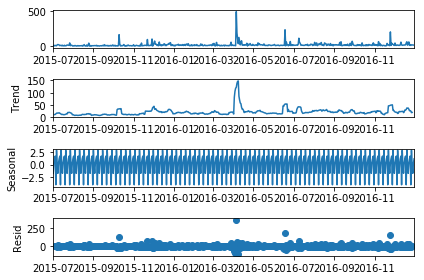

In [64]:
fig = seasonal_decompose(df_spider)
fig.plot();

In [66]:
from statsmodels.tsa.stattools import adfuller, kpss

In [67]:
adfuller(df_spider)

(-8.884037701518482,
 1.2946704090248327e-14,
 3,
 546,
 {'1%': -3.442383534871275,
  '5%': -2.8668480382580386,
  '10%': -2.569597004924258},
 5075.295013583333)

In [72]:
kpss(df_spider, nlags='auto', regression='ct')

/Users/henokyemam/opt/anaconda3/envs/experimentFB/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.1177169960988126,
 0.1,
 10,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

#### Statsmodels Forecasting

In [139]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product, permutations

In [132]:
pdqs = list(product(range(3), repeat=3))
#[(i, j, k) for i in range(3) for j in range(3) for k in range(3)]

In [174]:
result = [('order', 'aic', 'mae', 'rmse')]
for pdq in pdqs:
    model = ARIMA(train, order=pdq)
    res = model.fit()
    y_pred = res.predict()
    mae = np.round(mean_absolute_error(train, y_pred))
    rmse = np.round(mean_squared_error(train, y_pred, squared=False))
    result.append((pdq, np.round(res.aic), mae, rmse))

/Users/henokyemam/opt/anaconda3/envs/experimentFB/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/henokyemam/opt/anaconda3/envs/experimentFB/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/henokyemam/opt/anaconda3/envs/experimentFB/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/henokyemam/opt/anaconda3/envs/experimentFB/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Us

In [175]:
df_res = pd.DataFrame.from_records(result)
df_res.columns = result[0]
df_res = df_res.iloc[1:]
best_statsmodel = df_res.sort_values(by=['aic', 'mae', 'rmse']).head(1)
best_statsmodel

,order,aic,mae,rmse
15,"(1, 1, 2)",3879,11,31


In [168]:
# forecast into the future
test.shape

(150, 1)

In [180]:
statsmodel_best = ARIMA(train, order=(1, 1, 2))
statsmodel_best_res = statsmodel_best.fit()
forecast_stats = statsmodel_best_res.get_forecast(150).summary_frame()
forecast_stats.head()

traffic,mean,mean_se,mean_ci_lower,mean_ci_upper
2016-08-04,26.027125,30.809747,-34.358870,86.413119
2016-08-05,25.741434,31.526909,-36.050171,87.533040
2016-08-06,25.548269,31.875692,-36.926939,88.023477
2016-08-07,25.417663,32.052425,-37.403936,88.239261
2016-08-08,25.329355,32.146261,-37.676159,88.334869


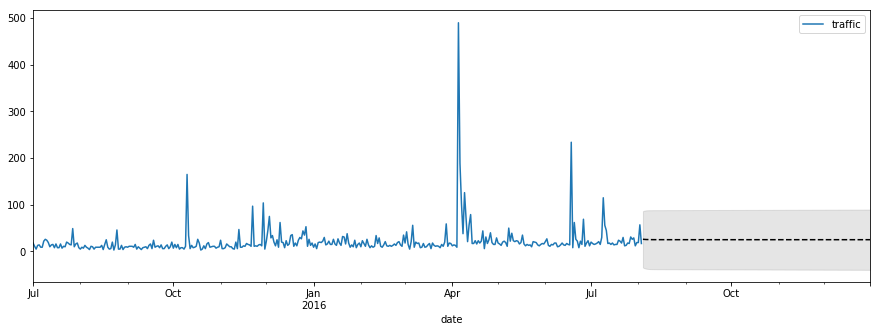

In [184]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax)
forecast_stats['mean'].plot(ax=ax,style='k--')
ax.fill_between(forecast_stats.index
                 , forecast_stats['mean_ci_lower']
                 , forecast_stats['mean_ci_upper']
                 , color='k', alpha=0.1);

### Prophet

In [185]:
from fbprophet import Prophet, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


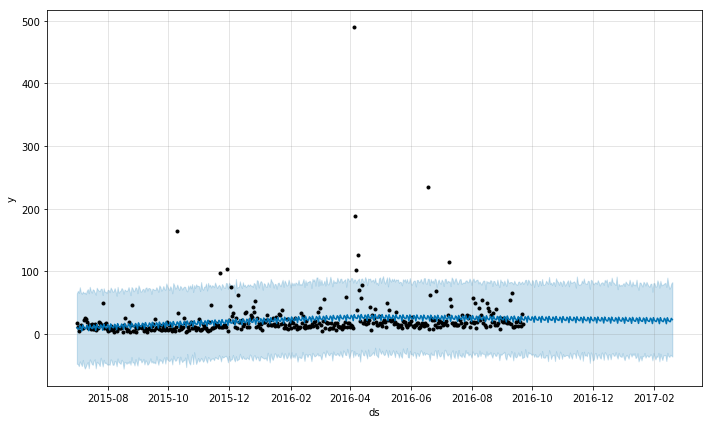

In [229]:
train_prophet = train.reset_index()
train_prophet.columns= ['ds', 'y']
model = Prophet(interval_width=0.95)
model.fit(train_prophet)
future = model.make_future_dataframe(periods=150)
forecast = model.predict(future)
model.plot(forecast);

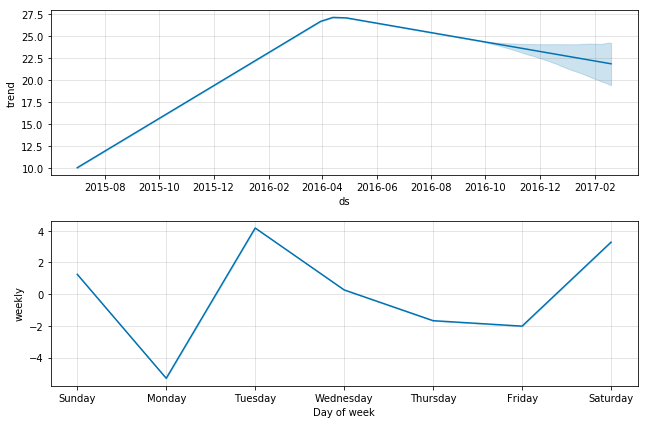

In [230]:
model.plot_components(forecast);

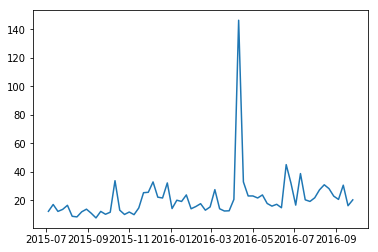

In [232]:
train_ts = train.copy()
train_ts = train_ts.resample('w').mean()
train_ts.index = pd.to_datetime(train_ts.index)
plt.plot(train_ts.index, train_ts.traffic);